In [1]:
import numpy as np
import pickle
import h5py
import matplotlib.pyplot as plt
import numba as nb

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

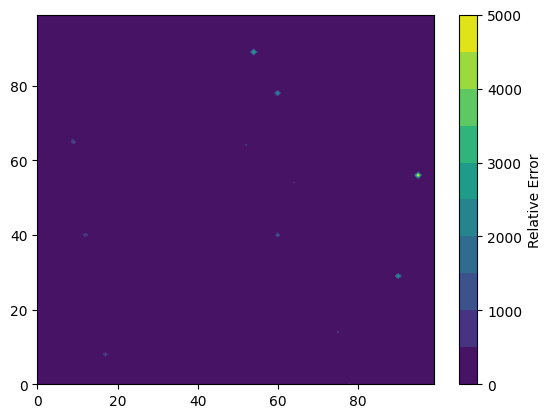

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create the learned surface and ground truth surface
learned_surface = np.random.rand(100, 100)
ground_truth_surface = np.random.rand(100, 100)

# Calculate the error between the two surfaces
error = np.abs(learned_surface - ground_truth_surface)

# Calculate the relative error
relative_error = error / ground_truth_surface

# Create a contourf plot of the relative error
plt.contourf(relative_error, levels=10)

# Add a colorbar
cbar = plt.colorbar()
cbar.ax.set_ylabel('Relative Error')

# Set the aspect ratio of the plot to 1
plt.set_aspect('equal')

# Plot the data points
data_points = np.random.rand(100, 2)
plt.scatter(data_points[:, 0], data_points[:, 1], c='r')

# Add a title and labels to the axes
plt.title('Relative Error Between Learned and Ground Truth Surfaces')
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.show()


In [2]:
#create a covariance matrix based on data at hand
@nb.njit(cache=True)
def covMat(coordinates1, coordinates2, covLambda, covL):

    #Create empty matrix for covariance
    C = np.zeros((len(coordinates1), len(coordinates2)))
    
    #loop over all indices in covariance matrix
    for i in range(len(coordinates1)):
        for j in range(len(coordinates2)):
            #Calculate distance between points
            dist = np.sqrt((coordinates1[i,0] - coordinates2[j,0])**2 + (coordinates1[i,1] - coordinates2[j,1])**2)
            #Determine each element of covariance matrix
            C[i, j] = (covLambda**2)*(np.exp(((-1)*((dist)**2))/(covL**2)))

    #Return Covariance Matrix
    return C

In [6]:
# Read the CSV file, considering the header
data = np.genfromtxt('C:/Users/vkuma/PresseLab/Research/Data/CleanData/movie011.txt', delimiter=', ', skip_header=1)

# Separate columns into individual arrays
dataVectIndex = data[:, 0]
dataVect = data[:, 1:]
    
#make pixel adjustment to nanometers
dataVect = dataVect[::]*97
dataVectIndex = dataVectIndex[::]
    
#put time step manually as unavailable from data file
deltaT = 1/30

In [7]:
#Points of trajectory where learning is possible
nData = len(dataVect)
dataCoordinates = np.empty((0,2))
for i in range(nData-1):
    if (dataVectIndex[i] == dataVectIndex[i+1]):
        dataCoordinates = np.vstack((dataCoordinates, dataVect[i]))

#Points of trajectory that are "sampled"
sampleCoordinates = np.empty((0,2))
for i in range(1,nData):
    if (dataVectIndex[i] == dataVectIndex[i-1]):
        sampleCoordinates = np.vstack((sampleCoordinates, dataVect[i]))

In [21]:
#Define function that establishes form of diffusion coefficient through space use (nm^2)/s as units
def diffusion(x, y):
    value = (1e5 + 50000*(np.sin(x/10000)+np.sin(y/10000)) + 
            20000*np.exp(-((x-5000)**2+(y-5000)**2)/1e7) + 
            20000*np.exp(-((x-10000)**2+(y-7500)**2)/1e7) + 
            20000*np.exp(-((x-15000)**2+(y-17500)**2)/1e7) + 
            20000*np.exp(-((x-5000)**2+(y-17500)**2)/1e7) + 
            20000*np.exp(-((x-17500)**2+(y-17500)**2)/1e7) + 
            20000*np.exp(-((x-2500)**2+(y-2500)**2)/1e7))
    return np.abs(value/8)

In [11]:
#Extract specifics from data namespace
xData = dataVect[:, 0]
yData = dataVect[:, 1]
nTraj = np.max(dataVectIndex)
nData = len(xData)

#initial constants
fieldOfView = [np.min(xData), np.max(xData), np.min(yData), np.max(yData)]  #[Xmin, Xmax, Ymin, Ymax] in nm for field of view
averageTrajLength = np.ceil(nData/nTraj)                                    #mean length of each trajectory
averageNumOfTraj = np.floor(nTraj/100)*100                                  #mean for the number of trajectories as a multiple of 10

#particle return tracker, this makes sure to count a particle leaving and 
#then returning in the field of view as two separate particles
tracker = 0
flag = False

# Learn the biased grid based on the dat
# Define the grid parameters
nGrid = 500
grid_size = (500, 500)  # Number of grid cells in each dimension

# Calculate the width and height of each grid cell
gridWidth = (fieldOfView[1] - fieldOfView[0]) / nGrid
gridHeight = (fieldOfView[3] - fieldOfView[2]) / nGrid

# Initialize an empty grid for density values
density_grid = np.zeros(grid_size)

# Iterate through the x and y coordinates
for x, y in zip(xData, yData):  # Replace x_coordinates and y_coordinates with your actual data
    # Map the (x, y) coordinate to the corresponding grid cell indices
    grid_x = int((x - fieldOfView[0]) / (fieldOfView[1] - fieldOfView[0]) * (grid_size[0] - 1))
    grid_y = int((y - fieldOfView[2]) / (fieldOfView[3] - fieldOfView[2]) * (grid_size[1] - 1))

    # Increment the density value for the corresponding grid cell
    density_grid[grid_y, grid_x] += 1

# Normalize the density values
biasValues = density_grid/np.sum(density_grid)  # Normalize by dividing by the total number of data points

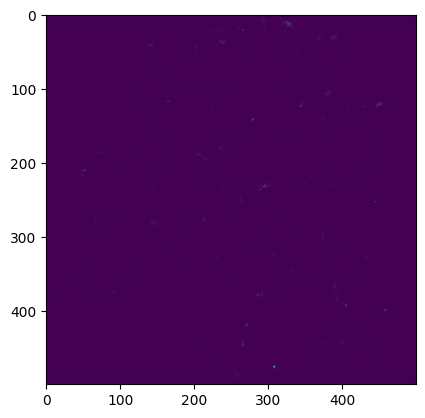

In [12]:
plt.imshow(biasValues)

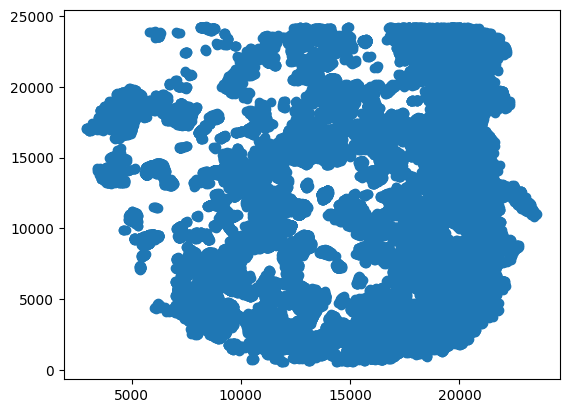

In [13]:
plt.scatter(dataVect[:, 0], dataVect[:, 1])

In [22]:
xVect = []
yVect = []
particleIndex = []

# Generate data with biased initialization
for i in range(1, int(nTraj) + 1):
    # Sample a grid cell based on the bias values
    gridProbs = biasValues.flatten() / np.sum(biasValues)  # Normalize the bias values to probabilities
    selectedGrid = np.random.choice(np.arange(nGrid**2), p=gridProbs)
    gridX = selectedGrid % nGrid
    gridY = selectedGrid // nGrid

    # Calculate the boundaries of the selected grid cell
    gridMinX = fieldOfView[0] + gridX * gridWidth
    gridMaxX = gridMinX + gridWidth
    gridMinY = fieldOfView[2] + gridY * gridHeight
    gridMaxY = gridMinY + gridHeight

    # Initialize positions within the selected grid cell
    xPrev = np.random.uniform(gridMinX, gridMaxX)
    yPrev = np.random.uniform(gridMinY, gridMaxY)

    xVect.append(xPrev)
    yVect.append(yPrev)
    particleIndex.append(i + tracker)

    # Sample trajectory length from a geometric distribution with mean 20 and minimum length of 5
    trajLength = 4 + np.random.geometric(p=1/20)

    # Loop through the full length of each trajectory
    for j in range(1, trajLength + 1):
        # Sample diffusion
        dPoint = diffusion(xPrev, yPrev)
        sd = np.sqrt(2 * dPoint * 1/30)
        xNew = np.random.normal(xPrev, sd)
        yNew = np.random.normal(yPrev, sd)

        # Save new positions if the particle is in the field of view
        if (fieldOfView[0] <= xNew <= fieldOfView[1]) and (fieldOfView[2] <= yNew <= fieldOfView[3]):
            # This part should be considered a new trajectory
            xVect.append(xNew)
            yVect.append(yNew)
            if flag:
                tracker += 1
                particleIndex.append(i + tracker)
                flag = False
            else:
                particleIndex.append(i + tracker)
        else:
            flag = True

        # Update positions
        xPrev = xNew
        yPrev = yNew

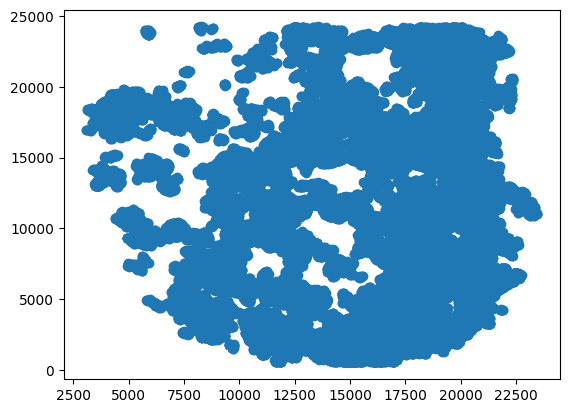

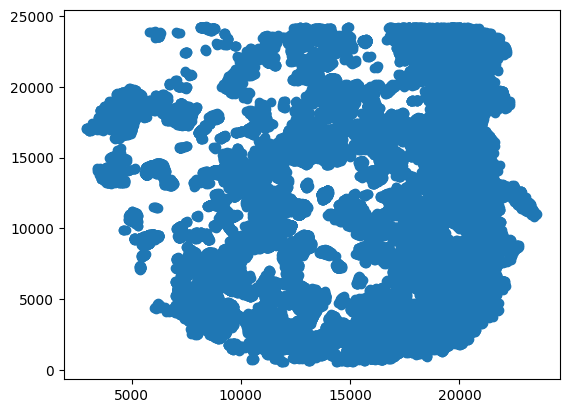

In [23]:
plt.scatter(xVect, yVect)
plt.figure()
plt.scatter(dataVect[:, 0], dataVect[:, 1])